# LAB 3: Speech-to-text with RNN



![alt text](https://miro.medium.com/max/556/1*NhOH4X9wKWfO6o8faYFf-w.png)

# Introduction

In this lab, we are going to use Recurrent Neural Networks to do some Speech Recognition.

Nowadays, speech recognition is a common task present in smart home assistants (Amazon Echo, Google Home), phones, TVs... Most of the time, it is done using deep learning.

## What you will learn

- The different kinds of RNN (RNN, LSTM, GRU...)

- How to load and process audio data in PyTorch

- How to implement an RNN in PyTorch

- How to create a confusion matrix


## RNN

Recurrent Neural Networks are a kind of Neural Network used to process **sequences** of data.
These sequences can be of varying length and usually have some context information.

For example, sentences (text), audio, videos have some temporal logic. In a sentence, one word depends on the word that comes before it. In a video, one frame probably looks a lot like the previous frames.

RNNs have some kind of **persistence** of information during the processing of a sequence. Thus, RNNs are used for lots of things: sentiment analysis, text completion, speech recognition, etc.

![alt text](https://www.researchgate.net/profile/Weijiang_Feng/publication/318332317/figure/fig1/AS:614309562437664@1523474221928/The-standard-RNN-and-unfolded-RNN.png)

## LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit)

**RNN Short-term memory problem:**

*   Recurrent Neural Networks suffer from short-term memory. If a sequence is long enough, they’ll have a hard time carrying information from earlier time steps to later ones. So if you are trying to process a paragraph of text to do predictions, RNN’s may leave out important information from the beginning.

*  During back propagation, recurrent neural networks suffer from the vanishing gradient problem. Gradients are values used to update a neural networks weights. The vanishing gradient problem is when the gradient shrinks as it back propagates through time. If a gradient value becomes extremely small, it doesn’t contribute too much to the learning.

**As solution to short-term memory, LSTM and GRU were created:**

*   LSTM was introduced by this [article](https://www.bioinf.jku.at/publications/older/2604.pdf).
*   GRU was introduced by this [article](https://arxiv.org/pdf/1412.3555.pdf).

Both are **Reccurent Neural Network (RNN)** architectures which were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information.

![alt text](http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)









These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions.

**LSTM**

The LSTMs does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

*   the **cell state** make easy for the information to pass through the cell by combining the cells decisions
*   the **forget gate** decides what information should be thrown away from the cell state
*   the **input gate** decides which values we'll update using sigmoid ; it's combined with a tanh layer to create an update to the state
*   the **output gate**, based on the celle state, output a filtered information

**GRU**

The GRU is a modified version of the LSTM. It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.



## Libraries

Since we are working with PyTorch and sounds, we are going to use *torchaudio* instead of *torchvision*, this time.

Make sure you are using a GPU Runtime! (Runtime -> Change Runtime type)

In [ ]:
# Workaround for torchcodec/FFmpeg issues in torchaudio 2.9+
# We'll monkey-patch torchaudio.load to use soundfile backend
import torchaudio
import soundfile as sf
import torch

_original_load = torchaudio.load

def _patched_load(uri, *args, **kwargs):
    # Use soundfile to load audio instead of torchcodec
    data, sample_rate = sf.read(uri, dtype='float32')
    # Convert to torch tensor and ensure correct shape (channels, samples)
    waveform = torch.from_numpy(data)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)  # mono: add channel dim
    else:
        waveform = waveform.T  # stereo: transpose to (channels, samples)
    return waveform, sample_rate

torchaudio.load = _patched_load


Patched torchaudio.load to use soundfile backend


In [ ]:
from IPython.display import Audio

## PyTorch things
import torch
# torchaudio is already imported above with soundfile backend
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

# Part 1: Working with audio data

The dataset we are using is Google's Speech Dataset (https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

It is composed of **"65,000 one-second long utterances of 30 short words, by thousands of different people"**.

Let's download the dataset:

In [2]:
!rm -rf ./*
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz
!ls

--2026-01-08 22:48:48--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4023:1002::cf, 2607:f8b0:4023:1000::cf, 2607:f8b0:4023:100d::cf, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4023:1002::cf|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   110MB/s    in 13s     

2026-01-08 22:49:01 (105 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

_background_noise_                    on
bed                                   one
bird                                  README.md
cat                                   right
dog                                   seven
down                                  sheila
eight                                 six
five                                  speech_

Let's print the different classes (words) that are part of this dataset.

We can see there are 30 different words.

In [57]:
# Define the 30 valid word classes explicitly
classes = [
    'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy',
    'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven',
    'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero'
]
print(classes)
print("Number of classes", len(classes))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Number of classes 30


## Q1: Listen to some samples

Using the **Audio(filename)** function from IPython notebook, you can listen to an audio file directly in Colab.

Try it on some samples!

In [4]:
Audio("bed/1528225c_nohash_2.wav")

In [5]:
Audio("one/0a7c2a8d_nohash_0.wav")

## Q2: Displaying a waveform

Use **torchaudio.load** to load an audio file. Then, use matplotlib to display it.

HINT: you may have to transpose the waveform with **.t()** in order to display it

Waveform shape: torch.Size([1, 16000])


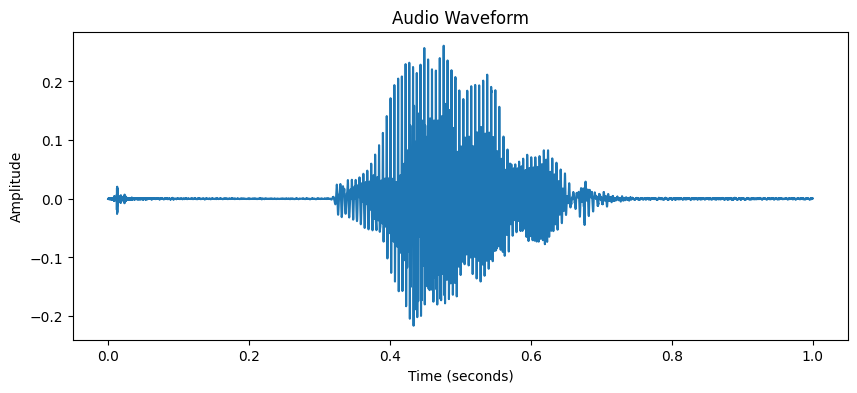

1.0

In [ ]:
waveform, sample_rate = torchaudio.load("one/0a7c2a8d_nohash_0.wav")
print("Waveform shape:", waveform.shape)

# Create time axis in seconds
time = np.linspace(0, waveform.shape[1] / sample_rate, waveform.shape[1])

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, waveform.t().numpy())
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform")
plt.show()



## Computing MFCC features

Extracting MFCC (**Mel Frequency Cepstral Coefficients**) features is a well known signal processing technique, especially used in **ASR** (Automatic Speech Recognition). These features are meant to represent the way humans perceive sound. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

*Torchaudio* has transforms (just like the ones in *torchvision*) that allow you to compute these features:

torch.Size([1, 12, 81])


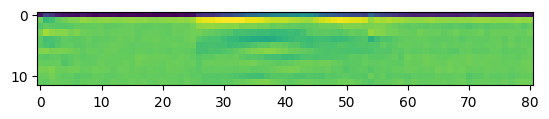

In [58]:
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

Here, we are only keeping 12 MFCC features because it is enough for our purposes.

As you can see, we are getting a Tensor of shape [1, 12, 81], because we have one audio channel (mono) with 12 coefficients over 81 time windows.

## Creating a custom audio Dataset

You may have noticed that in this dataset, the test and validation datasets are given in testing_list.txt and validation_list.txt files.

With that, we can infer a training list as well:

In [59]:
## Read the test list
with open("testing_list.txt") as testing_f:
  testing_list = [x.strip() for x in testing_f.readlines()]

## Read the val list
with open("validation_list.txt") as val_f:
  validation_list = [x.strip() for x in val_f.readlines()]

print("Number of testing samples", len(testing_list))
print("Number of validation samples", len(validation_list))

## Construct a train list
training_list = []
for c in classes:
  # Only add .wav files (to avoid picking up any non-audio files)
  training_list += glob.glob(c + "/*.wav")

training_list = list(filter(lambda x : not x in testing_list and not x in validation_list, training_list))
print("Number of training samples", len(training_list))

Number of testing samples 6835
Number of validation samples 6798
Number of training samples 51088


Now, we can create a custom SpeechDataset class that takes a file list in input.

In [60]:
class SpeechDataset(torch.utils.data.Dataset):

  def __init__(self, classes, file_list):

    self.classes = classes

    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))

    # store the file names
    self.samples = file_list

    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      waveform,_ = torchaudio.load(self.samples[i], normalize=True)

      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)

      # then, we apply the transform
      mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)

    # get the label from the file name
    label = self.samples[i].split("/")[0]

    # return the mfcc coefficient with the sample label
    return mfcc, self.class_to_int[label]

## Q3: Create instances of the SpeechDataset for the train and val sets

Fill the code below to create your Dataset objects for training.

In [61]:
train_set = SpeechDataset(classes, training_list)
val_set = SpeechDataset(classes, validation_list)

## Q4: Create Dataloaders for training and validation

Fill the code below to create DataLoaders with the Datasets you just created.

Do not forget to add shuffling to the training DataLoader.

Print a batch of data to make sure everything works.

In [62]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

# Part 2: Implementing a simple Recurrent Neural Network

For our network, we are going to use an **RNN module** from torch.nn (which can have multiple layers, or cells).

This module has an **input size**, which in our case will be equal to **the number of MFCC features (12)**. The input size is the number of dimensions of **x** in the image below.

It also has an **hidden size**, which is the size of the output of the layers as well as the size of the internal representation of the features. We are going to choose **256** to start, but feel free to change that. This is the dimension of **h** in the image below.

PyTorch RNN modules have a **number of layers**, which is simply the number of stacked **RNN Cells**. We are going to use 2 cells here, but feel free to change that as well. This is the **depth** in the image below.

Then, in order to get as many output as the number of classes in our dataset, we need to have a **Linear layer** that goes from **256 inputs (the hidden size) to 30 outputs (the number of classes).**

Finally, to output categorical probabilities, we use a **Softmax layer.**

![alt text](https://i.stack.imgur.com/SjnTl.png)

## Q4: Implement the network

Fill the code below to implement the network.

In [63]:
class SpeechRNN(torch.nn.Module):

  def __init__(self):
    super(SpeechRNN, self).__init__()

    self.lstm = torch.nn.LSTM(
      input_size=12,       # 12 MFCC features
      hidden_size=256,     # hidden state size
      num_layers=2,        # 2 stacked LSTM cells
      batch_first=True,    # input shape: (batch, seq, features)
      dropout=0.3          # dropout for regularization
    )

    self.out_layer = torch.nn.Linear(256, 30)  # 256 hidden -> 30 classes

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):

    out, _ = self.lstm(x)

    x = self.out_layer(out[:,-1,:])  # take last time step output

    return self.softmax(x)

Use this code to check that your implementation is working.

In [64]:
net = SpeechRNN()
batch = next(iter(train_dl))[0]
print(batch.shape)
y = net(batch)

print(y.shape)

torch.Size([64, 81, 12])
torch.Size([64, 30])


# Part 3: Training the network

As usual, we need to define a loss and an optimizer. Since we have a categorical classification problem, we use cross-entropy (negative log likelihood).

We can use the Adam optimizer, feel free to change it or the learning rate.

In [65]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = SpeechRNN()

## Move it to the GPU
net = net.to('mps')

# Negative log likelihood loss
criterion = torch.nn.NLLLoss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Q5: Training loop

We also need to write a training loop. Fill the code below to create it:

In [66]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):

  print("EPOCH:",e)

  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0

  ## Put the network in training mode
  net.train()

  for i, batch in enumerate(tqdm_notebook(train_dl)):

    # Get data and labels from batch
    x = batch[0].to('mps')
    labels = batch[1].to('mps')

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    y = net(x)

    # Compute loss
    loss = criterion(y, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()

  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))

  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))

  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()

  running_val_loss = 0
  running_val_accuracy = 0

  for i, batch in enumerate(val_dl):

    with torch.no_grad():
      # Get data and labels from batch
      x = batch[0].to('mps')
      labels = batch[1].to('mps')

      # Forward pass
      y = net(x)

      # Compute loss
      loss = criterion(y, labels)

      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()

  print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))

  epoch_val_loss.append(running_val_loss/len(val_set))
  epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0


/var/folders/cc/xvz0pw_n3dvg2s2hgjg4byk80000gn/T/ipykernel_37756/939382863.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dl)):


  0%|          | 0/799 [00:00<?, ?it/s]

Training accuracy: 0.6058369871594113 Training loss: 0.020515851396454787
Validation accuracy: 0.8003824654310091 Validation loss: 0.010517768201257384
EPOCH: 1


  0%|          | 0/799 [00:00<?, ?it/s]

Training accuracy: 0.8445623238333855 Training loss: 0.008164654204997008
Validation accuracy: 0.8599588114151221 Validation loss: 0.007405658910408831
EPOCH: 2


  0%|          | 0/799 [00:00<?, ?it/s]

Training accuracy: 0.8923034763545256 Training loss: 0.00575251864444965
Validation accuracy: 0.8829067372756693 Validation loss: 0.006368636470655197
EPOCH: 3


  0%|          | 0/799 [00:00<?, ?it/s]

Training accuracy: 0.9086282492953336 Training loss: 0.004751460548260445
Validation accuracy: 0.8952633127390409 Validation loss: 0.005605406559281496
EPOCH: 4


  0%|          | 0/799 [00:00<?, ?it/s]

Training accuracy: 0.9199616348261823 Training loss: 0.004156133134546318
Validation accuracy: 0.8905560458958517 Validation loss: 0.0059105647411652265


## Q6: From RNN to LSTM/GRU

As you can see, the accuracy is pretty bad when we are only using "regular" RNNs. These are not used very much in practice nowadays because they do not have long-term memory. This means that by the time the network is done processing the whole audio sample, it probably has already forgotten the important parts of it. **Replace the RNN module in your network (Q4) with an LSTM or a GRU module (as you want). Train a new network and watch that accuracy go up!**

# Part 4: Evaluation

Now, we need to evaluate our network on the test set.

Use the code below to do that:

In [67]:
# Create a test dataset instance
test_dataset = SpeechDataset(classes, testing_list)

# Create a DataLoader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=64)

net.eval()

test_loss = 0
test_accuracy = 0

preds, y_test = np.array([]), np.array([])

for i, batch in enumerate(test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.to('mps')
    labels = labels.to('mps')

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)

    ## Store all the predictions an labels for later
    preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
    y_test = np.hstack([y_test, labels.cpu().numpy()])

    test_loss += loss.item()
    test_accuracy += (y.max(1)[1] == labels).sum().item()

print("Test accuracy:", test_accuracy/float(len(test_dataset)),
      "Test loss:", test_loss/float(len(test_dataset)))

# Save the model
os.makedirs("models", exist_ok=True)
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': classes,
    'test_accuracy': test_accuracy/float(len(test_dataset))
}, "models/speech_lstm_model.pth")
print("Model saved to models/speech_lstm_model.pth")


Test accuracy: 0.8886613021214338 Test loss: 0.005821104935794829
Model saved to models/speech_lstm_model.pth


## Confusion matrix

In classification problems, it is common to use a confusion matrix to visualize which particular classes the model struggles with.

Use the code below to generate a confusion matrix. What is the confusion that your network makes the most?

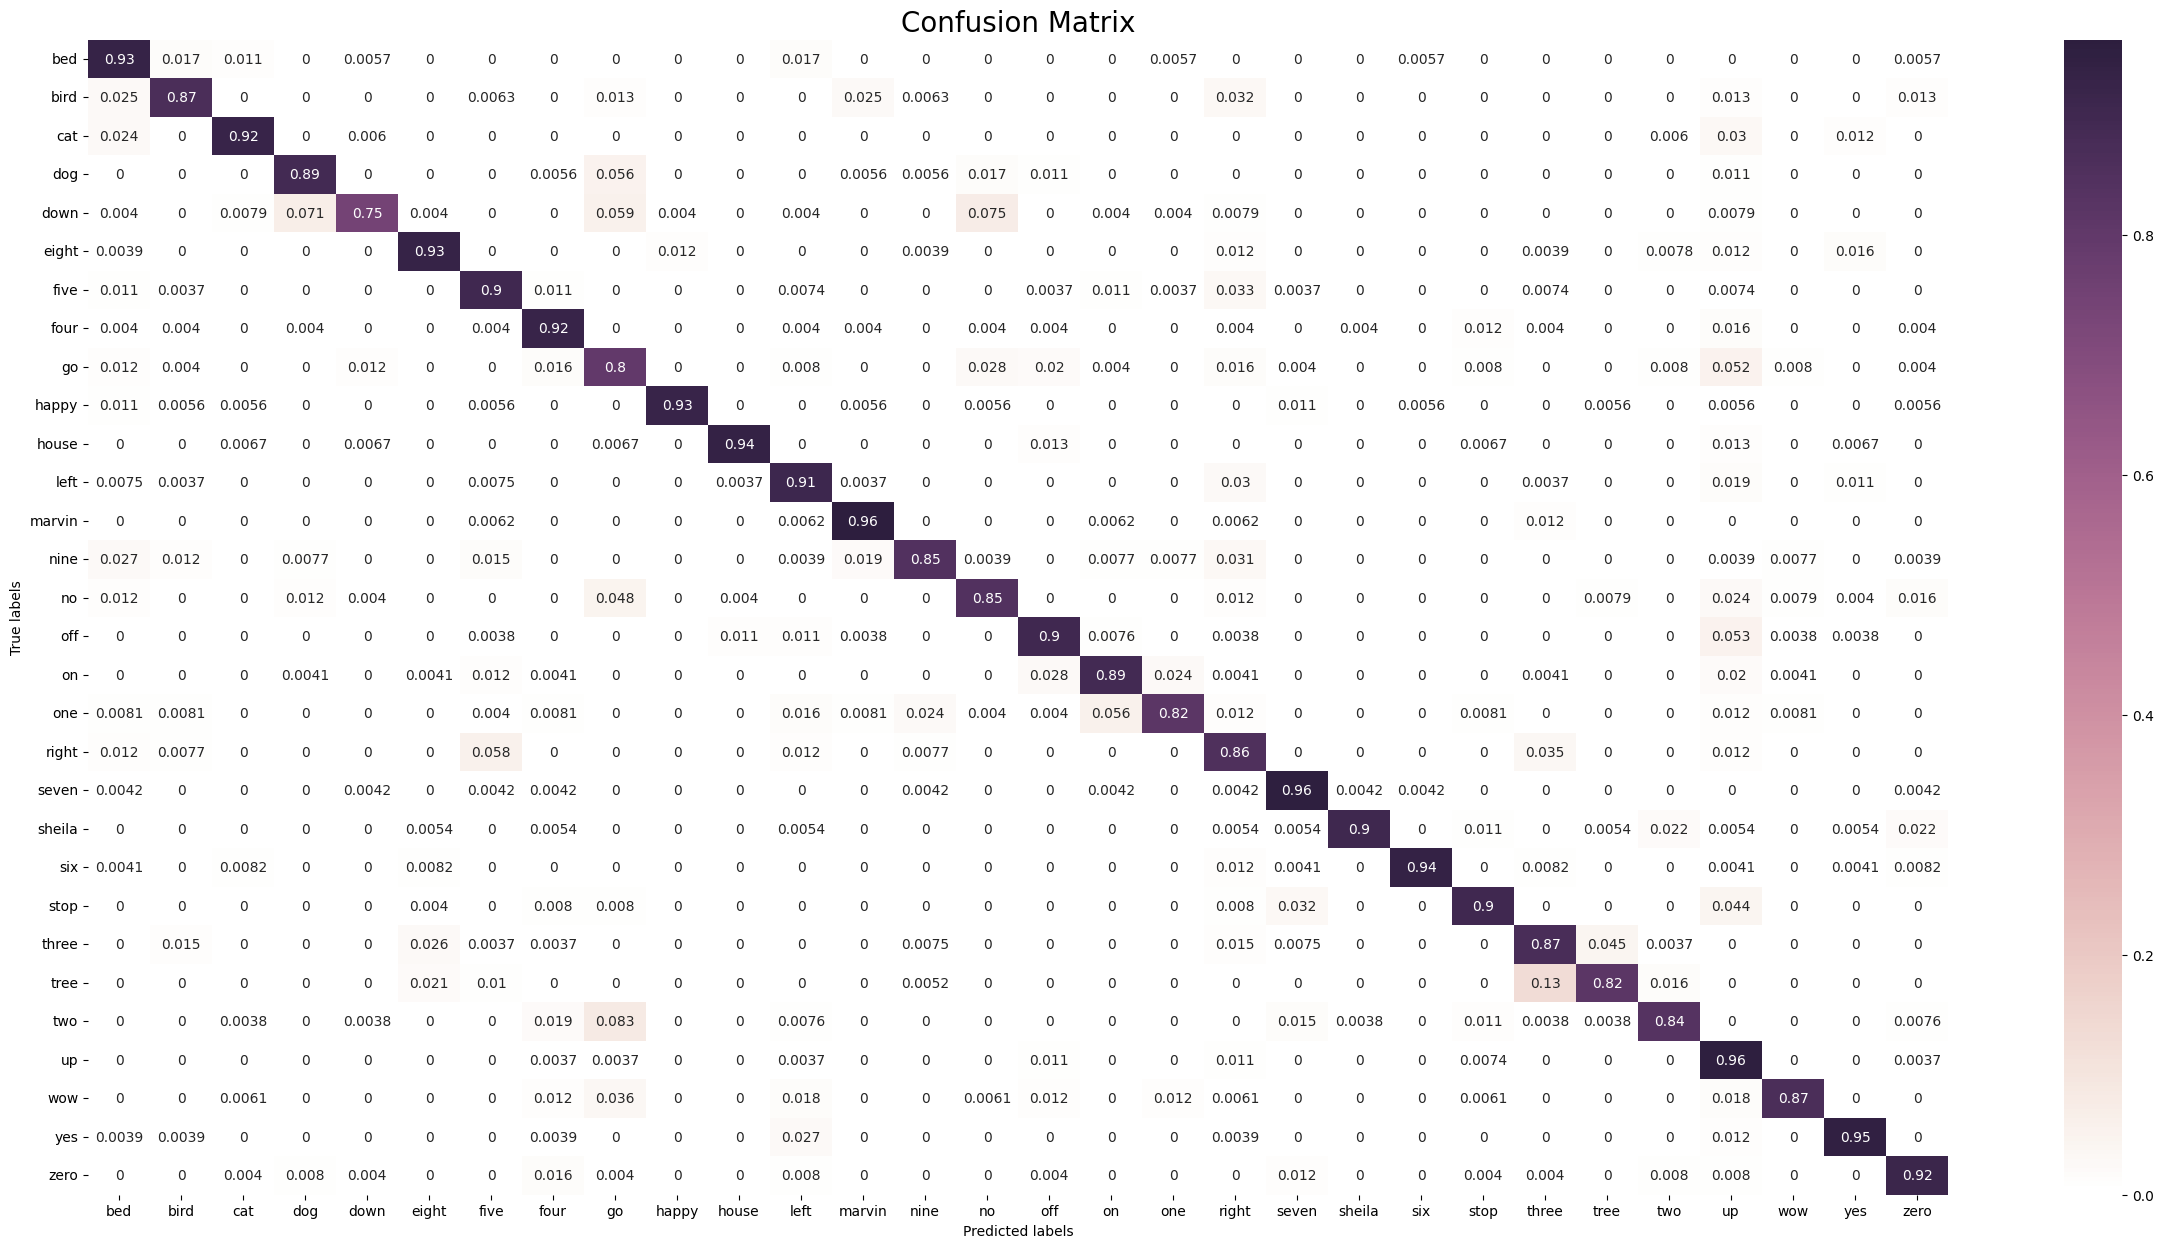

In [68]:
def show_confusion_matrix(pred, Y_TEST, classes):

  cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
  cm = normalize(cm,axis=1,norm='l1')

  df_cm = pd.DataFrame(cm, index = classes, columns = classes)

  plt.figure(figsize=(30,15))

  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show


show_confusion_matrix(preds, y_test, classes)

# (OPTIONAL) Part 5: Going further

## Kaggle audio recognition datasets

If you want to do more audio classification, there have been two competitions on Kaggle:

- https://www.kaggle.com/c/freesound-audio-tagging

- https://www.kaggle.com/c/freesound-audio-tagging-2019

![alt text](https://storage.googleapis.com/kaggle-media/competitions/freesound/task2_freesound_audio_tagging.png)

## More RNN things

There are lots of things you can do with RNN. Natural Language Processing (NLP) is really popular right now.
You can follow PyTorch tutorials to get started!

https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32

https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html